<a href="https://colab.research.google.com/github/duonghieu7104/Trend-Analysis-Aviation-Industry-US/blob/main/Milestone/Milestone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/duonghieu7104/Trend-Analysis-Aviation-Industry-US/blob/main/notebook/Market_Share.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count, mean, stddev, sum
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit

In [ ]:
 spark = SparkSession.builder \
    .appName("FlightRouteClassification") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()


In [ ]:
import kagglehub
path = kagglehub.dataset_download("bhavikjikadara/us-airline-flight-routes-and-fares-1993-2024")
print(f"Dataset downloaded to: {path}")

Dataset downloaded to: C:\Users\PC\.cache\kagglehub\datasets\bhavikjikadara\us-airline-flight-routes-and-fares-1993-2024\versions\1


In [ ]:
df = (
    spark.read
    .option("header", "true")
    .option("inferSchema", "true")
    .option("quote", '"')           # rất quan trọng: nhận diện text trong ngoặc kép
    .option("escape", '"')          # escape ký tự "
    .option("multiLine", "true")    # xử lý text có xuống dòng
    .option("mode", "PERMISSIVE")   # không drop dòng lỗi
    .option("nullValue", "")
    .option("nanValue", "NaN")
    .option("emptyValue", "")
    .csv(f"{path}/*.csv")
)

In [ ]:
df.printSchema()
print(f"\nSố dòng: {df.count()}")
print(f"Số cột: {len(df.columns)}")

root
 |-- tbl: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- citymarketid_1: integer (nullable = true)
 |-- citymarketid_2: integer (nullable = true)
 |-- city1: string (nullable = true)
 |-- city2: string (nullable = true)
 |-- airportid_1: integer (nullable = true)
 |-- airportid_2: integer (nullable = true)
 |-- airport_1: string (nullable = true)
 |-- airport_2: string (nullable = true)
 |-- nsmiles: integer (nullable = true)
 |-- passengers: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- carrier_lg: string (nullable = true)
 |-- large_ms: double (nullable = true)
 |-- fare_lg: double (nullable = true)
 |-- carrier_low: string (nullable = true)
 |-- lf_ms: double (nullable = true)
 |-- fare_low: double (nullable = true)
 |-- Geocoded_City1: string (nullable = true)
 |-- Geocoded_City2: string (nullable = true)
 |-- tbl1apk: string (nullable = true)


Số dòng: 245955
Số cột: 23


In [ ]:
df.show(5)


+-------+----+-------+--------------+--------------+--------------------+--------------------+-----------+-----------+---------+---------+-------+----------+------+----------+--------+-------+-----------+------+--------+--------------+--------------+--------------------+
|    tbl|Year|quarter|citymarketid_1|citymarketid_2|               city1|               city2|airportid_1|airportid_2|airport_1|airport_2|nsmiles|passengers|  fare|carrier_lg|large_ms|fare_lg|carrier_low| lf_ms|fare_low|Geocoded_City1|Geocoded_City2|             tbl1apk|
+-------+----+-------+--------------+--------------+--------------------+--------------------+-----------+-----------+---------+---------+-------+----------+------+----------+--------+-------+-----------+------+--------+--------------+--------------+--------------------+
|Table1a|2021|      3|         30135|         33195|Allentown/Bethleh...|Tampa, FL (Metrop...|      10135|      14112|      ABE|      PIE|    970|       180| 81.43|        G4|     1.0|

In [ ]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+---+----+-------+--------------+--------------+-----+-----+-----------+-----------+---------+---------+-------+----------+----+----------+--------+-------+-----------+-----+--------+--------------+--------------+-------+
|tbl|Year|quarter|citymarketid_1|citymarketid_2|city1|city2|airportid_1|airportid_2|airport_1|airport_2|nsmiles|passengers|fare|carrier_lg|large_ms|fare_lg|carrier_low|lf_ms|fare_low|Geocoded_City1|Geocoded_City2|tbl1apk|
+---+----+-------+--------------+--------------+-----+-----+-----------+-----------+---------+---------+-------+----------+----+----------+--------+-------+-----------+-----+--------+--------------+--------------+-------+
|  0|   0|      0|             0|             0|    0|    0|          0|          0|        0|        0|      0|         0|   0|      1540|    1540|   1540|       1612| 1612|    1612|         39206|         39206|      0|
+---+----+-------+--------------+--------------+-----+-----+-----------+-----------+---------+---------+-------+

In [ ]:
df.select('passengers', 'fare', 'large_ms', 'nsmiles', 'lf_ms').describe().show()

+-------+------------------+-----------------+------------------+-----------------+-------------------+
|summary|        passengers|             fare|          large_ms|          nsmiles|              lf_ms|
+-------+------------------+-----------------+------------------+-----------------+-------------------+
|  count|            245955|           245955|            244415|           245955|             244343|
|   mean| 299.4767945355858|218.9795867943276|0.6652516330831235|1189.812319326706|0.45043751243130975|
| stddev|511.38948561649295|82.37248581123856|0.2246346557290856|703.1434716080329| 0.3326690289129114|
|    min|                 0|             50.0|            0.0038|              109|               0.01|
|    max|              8301|           3377.0|               1.0|             2724|                1.0|
+-------+------------------+-----------------+------------------+-----------------+-------------------+



In [ ]:
df_clean = df.filter(col('large_ms').isNotNull())
print(f"\nKích thước dữ liệu sau khi loại bỏ dòng lỗi: {df_clean.count()} rows, {len(df_clean.columns)} columns")


Kích thước dữ liệu sau khi loại bỏ dòng lỗi: 244415 rows, 23 columns


In [ ]:
df_clean = df_clean.filter((col('large_ms') >= 0) & (col('large_ms') <= 1))
print(f"Số dòng sau khi làm sạch: {df_clean.count()}")

Số dòng sau khi làm sạch: 244415


In [ ]:
df_clean = df_clean.filter(
    (col('passengers') > 0) &
    (col('fare') > 0) &
    (col('nsmiles') > 0)
)

In [ ]:
df_clean = df_clean.dropna(subset=['carrier_low'])


In [ ]:

df_clean.select([
    sum(col(c).isNull().cast("int")).alias(c + "_nulls") for c in df_clean.columns
]).show()

+---------+----------+-------------+--------------------+--------------------+-----------+-----------+-----------------+-----------------+---------------+---------------+-------------+----------------+----------+----------------+--------------+-------------+-----------------+-----------+--------------+--------------------+--------------------+-------------+
|tbl_nulls|Year_nulls|quarter_nulls|citymarketid_1_nulls|citymarketid_2_nulls|city1_nulls|city2_nulls|airportid_1_nulls|airportid_2_nulls|airport_1_nulls|airport_2_nulls|nsmiles_nulls|passengers_nulls|fare_nulls|carrier_lg_nulls|large_ms_nulls|fare_lg_nulls|carrier_low_nulls|lf_ms_nulls|fare_low_nulls|Geocoded_City1_nulls|Geocoded_City2_nulls|tbl1apk_nulls|
+---------+----------+-------------+--------------------+--------------------+-----------+-----------+-----------------+-----------------+---------------+---------------+-------------+----------------+----------+----------------+--------------+-------------+-----------------+----

In [ ]:
print(f"Số dòng còn lại: {df_clean.count()}")


Số dòng còn lại: 237985


In [ ]:
df_features = df_clean.withColumn(
    'revenue', col('passengers') * col('fare')
).withColumn(
    'fare_per_mile', col('fare') / col('nsmiles')
).withColumn(
    'fare_difference', col('fare') - col('fare_low')
).withColumn(
    'is_largest_cheapest',
    when(col('carrier_lg') == col('carrier_low'), 1).otherwise(0)
)

In [ ]:
numeric_features = [
    'passengers', 'fare', 'nsmiles', 'lf_ms',
    'fare_low', 'revenue', 'fare_per_mile', 'fare_difference',
    'Year', 'quarter'
]

In [ ]:
categorical_features = ['carrier_lg', 'carrier_low']

In [ ]:
indexers = [
    StringIndexer(inputCol=col, outputCol=col+"_indexed", handleInvalid="keep")
    for col in categorical_features
]

In [ ]:
df_features.printSchema()

root
 |-- tbl: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- citymarketid_1: integer (nullable = true)
 |-- citymarketid_2: integer (nullable = true)
 |-- city1: string (nullable = true)
 |-- city2: string (nullable = true)
 |-- airportid_1: integer (nullable = true)
 |-- airportid_2: integer (nullable = true)
 |-- airport_1: string (nullable = true)
 |-- airport_2: string (nullable = true)
 |-- nsmiles: integer (nullable = true)
 |-- passengers: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- carrier_lg: string (nullable = true)
 |-- large_ms: double (nullable = true)
 |-- fare_lg: double (nullable = true)
 |-- carrier_low: string (nullable = true)
 |-- lf_ms: double (nullable = true)
 |-- fare_low: double (nullable = true)
 |-- Geocoded_City1: string (nullable = true)
 |-- Geocoded_City2: string (nullable = true)
 |-- tbl1apk: string (nullable = true)
 |-- revenue: double (nullable = true)
 |-- fare_per_m

# **1. Xây dựng mô hình dự đoán giá vé và lượng hành khách cho từng chuyến bay**

## 1.1 EDA - Phân tích ảnh hướng của khoảng cách đến giá vé

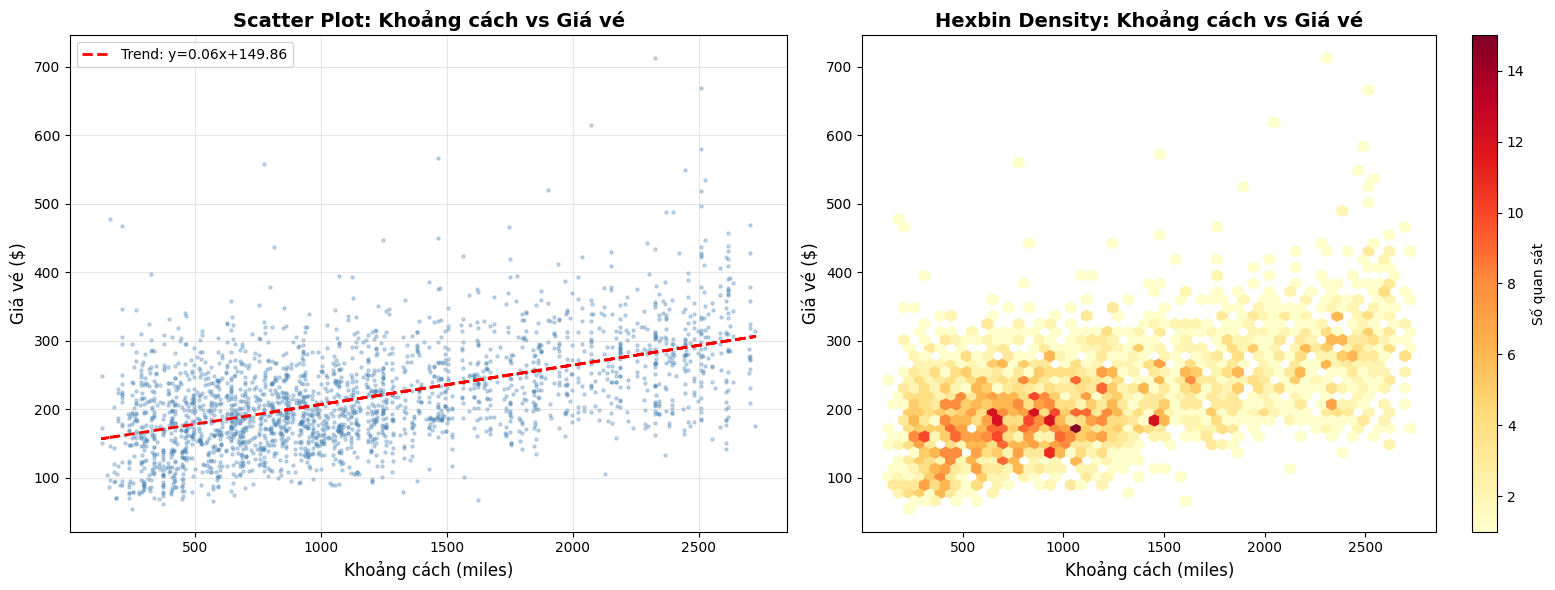


Hệ số tương quan Pearson: 0.5122


In [ ]:
# Mục đích: Trực quan hóa mối quan hệ giữa khoảng cách và giá vé

# Lấy mẫu dữ liệu
scatter_sample = df.select('nsmiles', 'fare').sample(False, sample_size, seed=42).toPandas()

# Tạo figure với 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Scatter plot thông thường
axes[0].scatter(scatter_sample['nsmiles'], scatter_sample['fare'],
                alpha=0.3, s=5, color='steelblue')
axes[0].set_xlabel('Khoảng cách (miles)', fontsize=12)
axes[0].set_ylabel('Giá vé ($)', fontsize=12)
axes[0].set_title('Scatter Plot: Khoảng cách vs Giá vé', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Thêm đường xu hướng (trend line)
z = np.polyfit(scatter_sample['nsmiles'], scatter_sample['fare'], 1)
p = np.poly1d(z)
axes[0].plot(scatter_sample['nsmiles'], p(scatter_sample['nsmiles']),
             "r--", linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
axes[0].legend(fontsize=10)

# 2. Hexbin plot (tốt hơn cho nhiều điểm)
hb = axes[1].hexbin(scatter_sample['nsmiles'], scatter_sample['fare'],
                     gridsize=50, cmap='YlOrRd', mincnt=1)
axes[1].set_xlabel('Khoảng cách (miles)', fontsize=12)
axes[1].set_ylabel('Giá vé ($)', fontsize=12)
axes[1].set_title('Hexbin Density: Khoảng cách vs Giá vé', fontsize=14, fontweight='bold')
cb = plt.colorbar(hb, ax=axes[1])
cb.set_label('Số quan sát', fontsize=10)

plt.tight_layout()
plt.show()

# In tương quan
corr_distance_fare = df.stat.corr("nsmiles", "fare")
print(f"\nHệ số tương quan Pearson: {corr_distance_fare:.4f}")

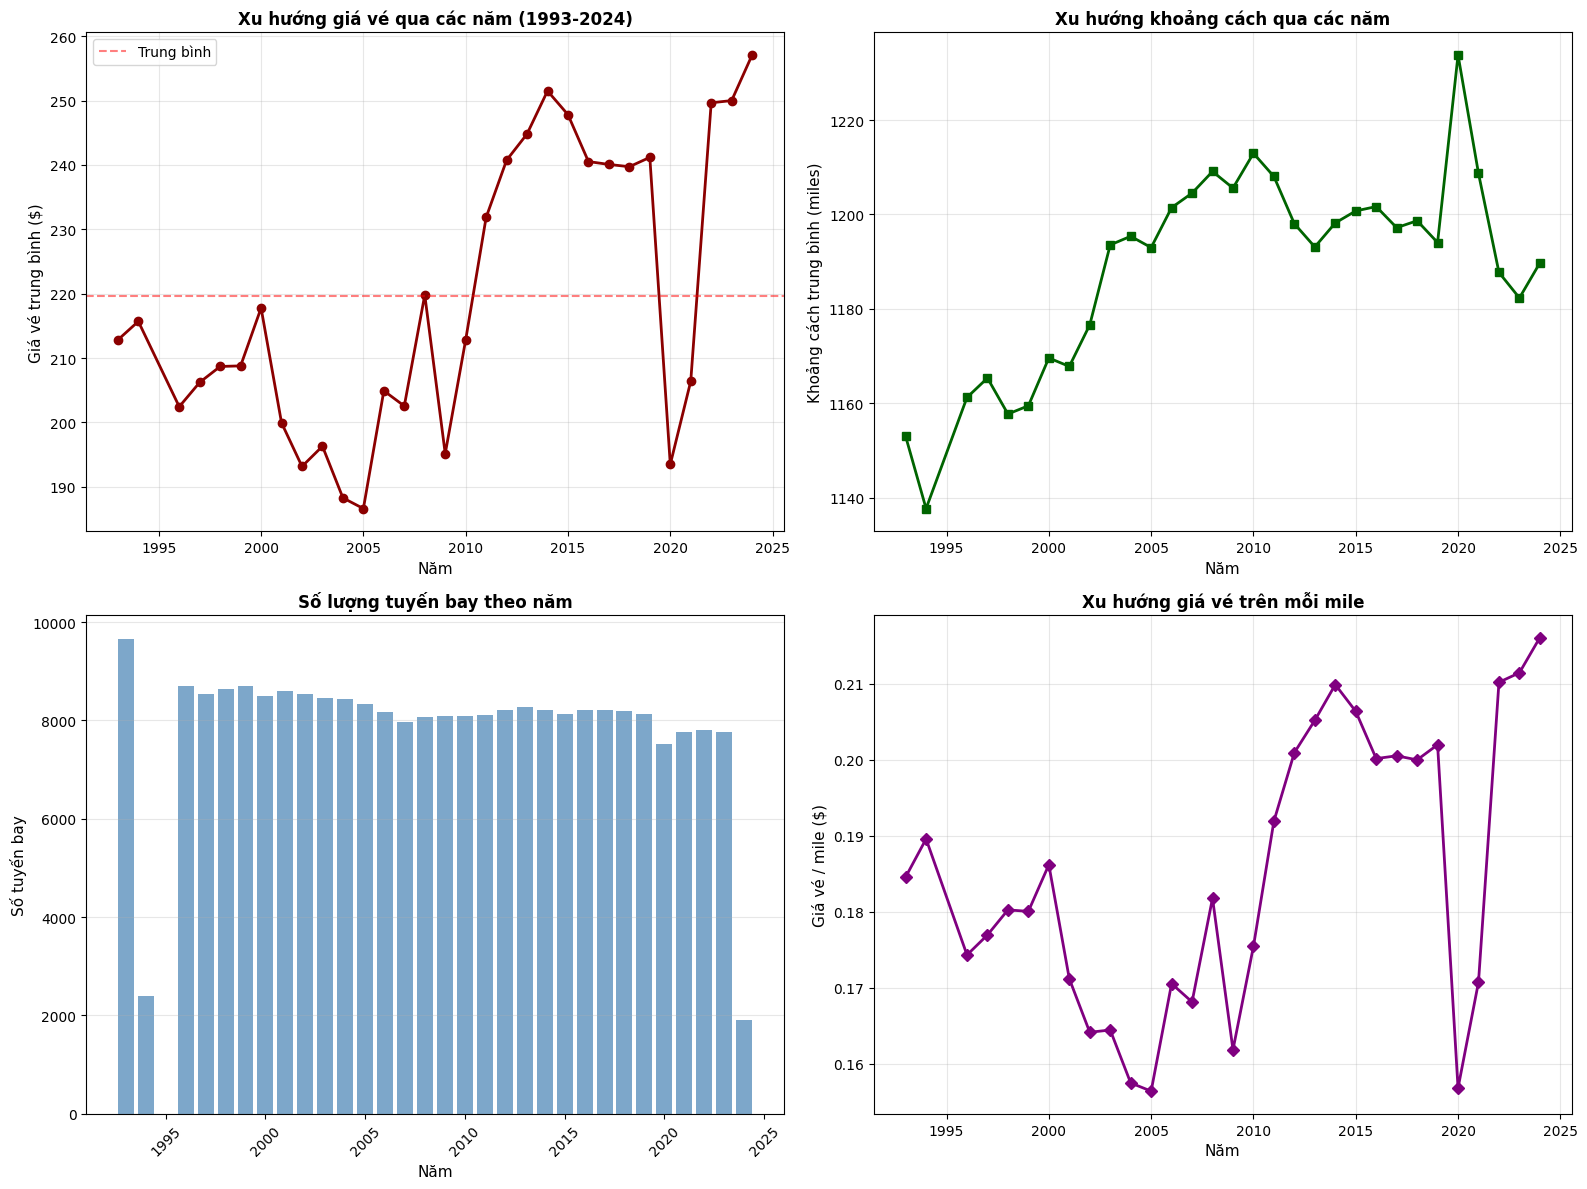

In [ ]:
# Tính trung bình theo năm
yearly_stats = df.groupBy('Year').agg(
    avg('fare').alias('gia_trung_binh'),
    avg('nsmiles').alias('khoang_cach_trung_binh'),
    avg('passengers').alias('hanh_khach_trung_binh'),
    count('*').alias('so_chuyen')
).orderBy('Year').toPandas()

# Tạo figure với 4 subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Giá vé trung bình theo năm
axes[0, 0].plot(yearly_stats['Year'], yearly_stats['gia_trung_binh'],
                marker='o', linewidth=2, markersize=6, color='darkred')
axes[0, 0].set_xlabel('Năm', fontsize=11)
axes[0, 0].set_ylabel('Giá vé trung bình ($)', fontsize=11)
axes[0, 0].set_title('Xu hướng giá vé qua các năm (1993-2024)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=yearly_stats['gia_trung_binh'].mean(),
                    color='r', linestyle='--', alpha=0.5, label='Trung bình')
axes[0, 0].legend()

# 2. Khoảng cách trung bình theo năm
axes[0, 1].plot(yearly_stats['Year'], yearly_stats['khoang_cach_trung_binh'],
                marker='s', linewidth=2, markersize=6, color='darkgreen')
axes[0, 1].set_xlabel('Năm', fontsize=11)
axes[0, 1].set_ylabel('Khoảng cách trung bình (miles)', fontsize=11)
axes[0, 1].set_title('Xu hướng khoảng cách qua các năm', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Số chuyến bay theo năm
axes[1, 0].bar(yearly_stats['Year'], yearly_stats['so_chuyen'],
               color='steelblue', alpha=0.7)
axes[1, 0].set_xlabel('Năm', fontsize=11)
axes[1, 0].set_ylabel('Số tuyến bay', fontsize=11)
axes[1, 0].set_title('Số lượng tuyến bay theo năm', fontsize=12, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Giá vé trên mỗi mile
yearly_stats['gia_per_mile'] = yearly_stats['gia_trung_binh'] / yearly_stats['khoang_cach_trung_binh']
axes[1, 1].plot(yearly_stats['Year'], yearly_stats['gia_per_mile'],
                marker='D', linewidth=2, markersize=6, color='purple')
axes[1, 1].set_xlabel('Năm', fontsize=11)
axes[1, 1].set_ylabel('Giá vé / mile ($)', fontsize=11)
axes[1, 1].set_title('Xu hướng giá vé trên mỗi mile', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
print("XỬ LÝ LỖI DỮ LIỆU - LOẠI BỎ VÉ KHÔNG CÓ HÀNH KHÁCH")

# Đếm số vé có passengers = 0
zero_pax = df.filter(col('passengers') == 0).count()
total = df.count()

print(f"\n1. PHÂN TÍCH:")
print(f"  Vé có passengers = 0: {zero_pax:,} ({zero_pax/total*100:.2f}%)")

# Xem phân phối giá của những vé này
print("\n2. PHÂN PHỐI GIÁ CỦA VÉ CÓ PASSENGERS = 0:")
df.filter(col('passengers') == 0).select('fare').describe().show()

print("\n3. QUYẾT ĐỊNH:")
print("  ✅ LOẠI BỎ tất cả vé có passengers = 0")
print("  LÝ DO:")
print("    • Không logic: vé không thể có giá nếu không có hành khách")
print("    • Chứa các outliers giá vé cao bất thường")
print("    • Dữ liệu không đáng tin cậy")

# Loại bỏ
df = df.filter(col('passengers') > 0)

print(f"\n4. KẾT QUẢ:")
print(f"  Đã loại bỏ: {zero_pax:,} dòng")
print(f"  Còn lại: {df.count():,} dòng")

# Kiểm tra lại giá vé cao nhất
max_fare = df.agg(max('fare')).collect()[0][0]
print(f"  Giá vé cao nhất sau xử lý: ${max_fare:,.2f}")

XỬ LÝ LỖI DỮ LIỆU - LOẠI BỎ VÉ KHÔNG CÓ HÀNH KHÁCH

1. PHÂN TÍCH:
  Vé có passengers = 0: 0 (0.00%)

2. PHÂN PHỐI GIÁ CỦA VÉ CÓ PASSENGERS = 0:
+-------+----+
|summary|fare|
+-------+----+
|  count|   0|
|   mean|NULL|
| stddev|NULL|
|    min|NULL|
|    max|NULL|
+-------+----+


3. QUYẾT ĐỊNH:
  ✅ LOẠI BỎ tất cả vé có passengers = 0
  LÝ DO:
    • Không logic: vé không thể có giá nếu không có hành khách
    • Chứa các outliers giá vé cao bất thường
    • Dữ liệu không đáng tin cậy

4. KẾT QUẢ:
  Đã loại bỏ: 0 dòng
  Còn lại: 237,985 dòng
  Giá vé cao nhất sau xử lý: $1,161.22


## 1.2 Xây dựng baseline model LINEAR REGRESSION (DISTANCE ONLY) để dự đoán giá vé

In [ ]:
# Mục đích: Tính toán các metrics đánh giá model

# Bước 1: Dự đoán trên test set
predictions_simple = model_simple.transform(test_data)

# Bước 2: Tính các metrics
evaluator_r2 = RegressionEvaluator(
    labelCol='fare',
    predictionCol='fare_pred',
    metricName='r2'
)

evaluator_rmse = RegressionEvaluator(
    labelCol='fare',
    predictionCol='fare_pred',
    metricName='rmse'
)

evaluator_mae = RegressionEvaluator(
    labelCol='fare',
    predictionCol='fare_pred',
    metricName='mae'
)

# Tính toán
r2_simple = evaluator_r2.evaluate(predictions_simple)
rmse_simple = evaluator_rmse.evaluate(predictions_simple)
mae_simple = evaluator_mae.evaluate(predictions_simple)

# Hiển thị kết quả
print("=" * 60)
print("KẾT QUẢ LINEAR REGRESSION (DISTANCE ONLY)")
print("=" * 60)
print(f"\nHiệu suất trên Test Set:")
print(f"  R² (R-squared):     {r2_simple:.4f}  ({r2_simple*100:.2f}%)")
print(f"  RMSE (Root MSE):    ${rmse_simple:.2f}")
print(f"  MAE (Mean Abs Err): ${mae_simple:.2f}")

print(f"\nGiải thích:")
print(f"  • R² = {r2_simple:.4f} nghĩa là model giải thích được {r2_simple*100:.1f}% biến thiên của giá vé")
print(f"  • Sai số trung bình: ±${rmse_simple:.2f}")
print(f"  • Sai số tuyệt đối trung bình: ${mae_simple:.2f}")

KẾT QUẢ LINEAR REGRESSION (DISTANCE ONLY)

Hiệu suất trên Test Set:
  R² (R-squared):     0.3049  (30.49%)
  RMSE (Root MSE):    $61.76
  MAE (Mean Abs Err): $48.45

Giải thích:
  • R² = 0.3049 nghĩa là model giải thích được 30.5% biến thiên của giá vé
  • Sai số trung bình: ±$61.76
  • Sai số tuyệt đối trung bình: $48.45


## 1.3  LINEAR REGRESSION (Nhiều Feature)

In [ ]:

# LINEAR REGRESSION - NHIỀU FEATURE

print("LINEAR REGRESSION - MULTI FEATURES")

# Chọn features
feature_cols = ['nsmiles', 'quarter', 'Year', 'passengers']

print(f"\n📋 FEATURES SỬ DỤNG:")
for i, feat in enumerate(feature_cols, 1):
    print(f"  {i}. {feat}")

# Bước 1: Tạo feature vector
assembler_multi = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features',
    handleInvalid='skip'
)

# Bước 2: Chuẩn hóa features
scaler_multi = StandardScaler(
    inputCol='features',
    outputCol='scaled_features',
    withStd=True,
    withMean=True
)

# Bước 3: Tạo Linear Regression model
lr_multi = LinearRegression(
    featuresCol='scaled_features',
    labelCol='fare',
    predictionCol='fare_pred_multi',
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.0,
    tol=1e-6
)

# Bước 4: Tạo pipeline
pipeline_multi = Pipeline(stages=[
    assembler_multi,
    scaler_multi,
    lr_multi
])

# Bước 5: Train model
print(f"\nĐang training model với {len(feature_cols)} features...")
model_multi = pipeline_multi.fit(train_data)
print("✓ Training hoàn thành!")

# Lưu model để dễ truy cập
lr_multi_model = model_multi.stages[-1]

LINEAR REGRESSION - MULTI FEATURES

📋 FEATURES SỬ DỤNG:
  1. nsmiles
  2. quarter
  3. Year
  4. passengers

Đang training model với 4 features...
✓ Training hoàn thành!


## 1.4 Mô hình phi tuyến

In [ ]:
# ============================================================
# CELL 7C: THỬ NGHIỆM NHIỀU POLYNOMIAL DEGREES
# ============================================================
# Mục đích: Tìm degree tối ưu, kiểm tra overfitting

print("=" * 70)
print("THỬ NGHIỆM NHIỀU POLYNOMIAL DEGREES")
print("=" * 70)

degrees = [1, 2, 3, 4]
results = []

for degree in degrees:
    print(f"\nĐang train với degree = {degree}...")

    # Tạo pipeline cho degree này
    poly_exp = PolynomialExpansion(
        degree=degree,
        inputCol='scaled_features',
        outputCol='poly_features'
    )

    lr_temp = LinearRegression(
        featuresCol='poly_features',
        labelCol='fare',
        predictionCol='fare_pred',
        maxIter=100,
        regParam=0.1,
        elasticNetParam=0.0
    )

    pipeline_temp = Pipeline(stages=[
        assembler_poly,
        scaler_poly,
        poly_exp,
        lr_temp
    ])

    # Train
    model_temp = pipeline_temp.fit(train_data)

    # Evaluate trên cả train và test
    pred_train = model_temp.transform(train_data)
    pred_test = model_temp.transform(test_data)

    r2_train = RegressionEvaluator(
        labelCol='fare', predictionCol='fare_pred', metricName='r2'
    ).evaluate(pred_train)

    r2_test = RegressionEvaluator(
        labelCol='fare', predictionCol='fare_pred', metricName='r2'
    ).evaluate(pred_test)

    rmse_train = RegressionEvaluator(
        labelCol='fare', predictionCol='fare_pred', metricName='rmse'
    ).evaluate(pred_train)

    rmse_test = RegressionEvaluator(
        labelCol='fare', predictionCol='fare_pred', metricName='rmse'
    ).evaluate(pred_test)

    # Tính số features
    num_features = pred_test.select('poly_features').first()[0].size

    results.append({
        'Degree': degree,
        'Num_Features': num_features,
        'R2_Train': r2_train,
        'R2_Test': r2_test,
        'RMSE_Train': rmse_train,
        'RMSE_Test': rmse_test,
        'Overfit_Gap': r2_train - r2_test
    })

    print(f"  ✓ Degree {degree}: R² Train={r2_train:.4f}, Test={r2_test:.4f}, Gap={r2_train-r2_test:.4f}")

# Tạo DataFrame
results_df = pd.DataFrame(results)

print(f"\n" + "=" * 70)
print("KẾT QUẢ TỔNG HỢP")
print("=" * 70)
print(results_df.to_string(index=False))

# Tìm degree tốt nhất
best_degree_idx = results_df['R2_Test'].idxmax()
best_degree = results_df.loc[best_degree_idx, 'Degree']
best_r2 = results_df.loc[best_degree_idx, 'R2_Test']

print(f"\n🏆 DEGREE TỐI ƯU: {int(best_degree)}")
print(f"  • R² Test: {best_r2:.4f}")
print(f"  • Overfitting gap: {results_df.loc[best_degree_idx, 'Overfit_Gap']:.4f}")

THỬ NGHIỆM NHIỀU POLYNOMIAL DEGREES

Đang train với degree = 1...
  ✓ Degree 1: R² Train=0.3490, Test=0.3535, Gap=-0.0045

Đang train với degree = 2...
  ✓ Degree 2: R² Train=0.3702, Test=0.3729, Gap=-0.0028

Đang train với degree = 3...
  ✓ Degree 3: R² Train=0.3959, Test=0.3957, Gap=0.0002

Đang train với degree = 4...
  ✓ Degree 4: R² Train=0.4041, Test=0.4042, Gap=-0.0000

KẾT QUẢ TỔNG HỢP
 Degree  Num_Features  R2_Train  R2_Test  RMSE_Train  RMSE_Test  Overfit_Gap
      1             4  0.349008 0.353508   60.001665  59.562801    -0.004499
      2            14  0.370176 0.372927   59.018086  58.661429    -0.002750
      3            34  0.395862 0.395705   57.802128  57.586128     0.000156
      4            69  0.404108 0.404155   57.406281  57.182091    -0.000047

🏆 DEGREE TỐI ƯU: 4
  • R² Test: 0.4042
  • Overfitting gap: -0.0000


## 1.5 Xây dựng mô hình dự đoán giá vé cho từng chuyến bay

In [ ]:

# ---- 1. Chuyển kiểu dữ liệu ----
df = df.withColumn("Year", col("Year").cast(IntegerType())) \
       .withColumn("quarter", col("quarter").cast(IntegerType())) \
       .withColumn("fare", col("fare").cast(DoubleType())) \
       .withColumn("fare_low", col("fare_low").cast(DoubleType()))

# ---- 2. Loại bỏ các cột không cần thiết ----
cols_to_drop = [c for c in ["Geocoded_City1", "Geocoded_City2", "tbl1apk", "city1", "city2"] if c in df.columns]
df = df.drop(*cols_to_drop)

# ---- 3. Loại bỏ null trong fare, passengers ----
df = df.na.drop(subset=["fare", "passengers"])

# ---- 4. Tạo các feature mới ----
from pyspark.sql.functions import pow

if all(c in df.columns for c in ["fare_lg", "fare_low"]):
    df = df.withColumn("fare_diff", col("fare_lg") - col("fare_low"))

if all(c in df.columns for c in ["large_ms", "lf_ms"]):
    df = df.withColumn(
        "hhi",
        pow(col("large_ms"), 2)
        + pow(col("lf_ms"), 2)
        + pow(1 - (col("large_ms") + col("lf_ms")), 2)
    )

if "nsmiles" in df.columns:
    df = df.withColumn("fare_per_mile", when(col("nsmiles") != 0, col("fare") / col("nsmiles")).otherwise(None))

print(" Tiền xử lý xong:", df.count(), "dòng,", len(df.columns), "cột")


 Tiền xử lý xong: 245955 dòng, 21 cột


In [ ]:

# --------------------------
# 1️⃣ Chia cột và dữ liệu
# --------------------------
num_features = ["Year", "quarter", "nsmiles", "passengers", "fare_diff", "hhi", "fare_per_mile"]
cat_features = [c for c in df.columns if c.startswith(("airport_", "carrier_"))]
target = "fare"

# --------------------------
# 2️⃣ Xử lý cột phân loại và scale
# --------------------------
indexers = [StringIndexer(inputCol=c, outputCol=c + "_index", handleInvalid="keep") for c in cat_features]
encoders = [OneHotEncoder(inputCol=c + "_index", outputCol=c + "_vec") for c in cat_features]

assembler_inputs = num_features + [c + "_vec" for c in cat_features]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# --------------------------
# 3️⃣ Chia dữ liệu Train/Test (dùng chung cho tất cả mô hình)
# --------------------------
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

print("Dữ liệu đã chia:")
print(f" - Train: {train_df.count()} dòng")
print(f" - Test:  {test_df.count()} dòng")



Dữ liệu đã chia:
 - Train: 196552 dòng
 - Test:  49403 dòng


### Random Forest

In [ ]:

# --------------------------
# 1️⃣ Tạo Pipeline mô hình Random Forest
# --------------------------
rf = RandomForestRegressor(labelCol=target, featuresCol="scaledFeatures", seed=42)

# Pipeline gồm toàn bộ xử lý
rf_model = Pipeline(stages=indexers + encoders + [assembler, scaler, rf])

# --------------------------
# 2️⃣ Tập siêu tham số cần thử
# --------------------------
param_grid = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [50,100,200])
    .addGrid(rf.maxDepth, [10, 15])
    .build()
)

# --------------------------
# 3️⃣ TrainValidationSplit (thay vì CrossValidator)
# --------------------------
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")

tvs = TrainValidationSplit(
    estimator=rf_model,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    trainRatio=0.8,    # 80% train, 20% validation
    parallelism=4      # chạy song song 4 job
)

# --------------------------
# 4️⃣ Huấn luyện
# --------------------------
rf_tvs_model = tvs.fit(train_df)

# --------------------------
# 5️⃣ In thông tin mô hình tốt nhất
# --------------------------
best_rf = rf_tvs_model.bestModel.stages[-1]
print("Best Parameters Found:")
print(" - numTrees:", best_rf._java_obj.getNumTrees())
print(" - maxDepth:", best_rf._java_obj.getMaxDepth())


Best Parameters Found:
 - numTrees: 200
 - maxDepth: 15


In [ ]:

# Sử dụng toàn bộ pipeline tốt nhất
train_pred = rf_tvs_model.bestModel.transform(train_df)
test_pred  = rf_tvs_model.bestModel.transform(test_df)


metrics = ['r2', 'mae', 'mse']
for metric in metrics:
    evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName=metric)
    print(f"{metric.upper()} Train:", round(evaluator.evaluate(train_pred), 4))
    print(f"{metric.upper()} Test :", round(evaluator.evaluate(test_pred), 4))
    print("----------")


R2 Train: 0.9621
R2 Test : 0.9482
----------
MAE Train: 9.5988
MAE Test : 10.4521
----------
MSE Train: 256.9823
MSE Test : 353.3241
----------


### Gradient Boosted Tree

In [ ]:

# 1️⃣ Khai báo mô hình GBT (tương tự XGB)
gbt = GBTRegressor(
    labelCol=target,
    featuresCol="scaledFeatures",
    seed=42
)

# 2️⃣ Xây dựng pipeline (đã có bước xử lý trước: indexers, encoders, assembler, scaler)
xgb_pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, gbt])

# 3️⃣ Tạo grid tham số để thử (tương tự param_dist_xgb)
paramGrid = (ParamGridBuilder()
    .addGrid(gbt.maxDepth, [4, 8])
    .addGrid(gbt.maxIter, [20, 40])   # tương đương n_estimators
    .addGrid(gbt.stepSize, [0.05, 0.1])  # tương đương learning_rate
    .build()
)

# 4️⃣ Đánh giá bằng R2
evaluator = RegressionEvaluator(
    labelCol=target,
    predictionCol="prediction",
    metricName="r2"
)

# 5️⃣ Chia train/validation (tương tự RandomizedSearchCV)
tvs = TrainValidationSplit(
    estimator=xgb_pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8,  # 80% train, 20% validation
    parallelism=4,
    seed=42
)

# 6️⃣ Huấn luyện và chọn mô hình tốt nhất
xgb_tvs_model = tvs.fit(train_df)

# 7️⃣ In kết quả tốt nhất
best_gbt = xgb_tvs_model.bestModel.stages[-1]

print("Best Parameters Found:")
print(" - maxDepth:", best_gbt.getOrDefault("maxDepth"))
print(" - maxIter:", best_gbt.getOrDefault("maxIter"))
print(" - stepSize:", best_gbt.getOrDefault("stepSize"))



Best Parameters Found:
 - maxDepth: 8
 - maxIter: 40
 - stepSize: 0.1


In [ ]:
train_pred = xgb_tvs_model.bestModel.transform(train_df)
test_pred  = xgb_tvs_model.bestModel.transform(test_df)

metrics = ['r2', 'mae', 'mse']
for metric in metrics:
    evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName=metric)
    print(f"{metric.upper()} Train:", round(evaluator.evaluate(train_pred), 4))
    print(f"{metric.upper()} Test :", round(evaluator.evaluate(test_pred), 4))
    print("----------")


R2 Train: 0.9736
R2 Test : 0.9656
----------
MAE Train: 7.6887
MAE Test : 7.9885
----------
MSE Train: 178.735
MSE Test : 234.3938
----------


#### Nhận xét

##### Hiệu suất tổng thể

Cả hai mô hình đều có **R² > 0.94**, tức là chúng giải thích được hơn **94% biến thiên của giá vé** → rất mạnh và có khả năng dự báo tốt.

Tuy nhiên, **GBT (Gradient Boosted Trees)** vượt trội hơn rõ rệt so với **Random Forest**:

| Mô hình | R² Train | R² Test | MAE Train | MAE Test | MSE Train | MSE Test |
|----------|-----------|----------|------------|-----------|------------|-----------|
| Random Forest | 0.9621 | 0.9482 | 9.5988 | 10.4521 | 256.9823 | 353.3241 |
| GBT | 0.9736 | 0.9656 | 7.6887 | 7.9885 | 178.735 | 234.3938 |

- GBT có **R² cao hơn** trên cả train và test → mô hình học tốt hơn.  
- **Sai số (MAE, MSE)** đều **thấp hơn** → dự đoán sát hơn với giá thực tế.  
**GBT Regression** là mô hình **tốt hơn** cho bài toán dự đoán giá vé

## 1.6 Mô hình dự đoán _số lượng hành khách_ trên một chuyến bay

In [ ]:

# Xử lý dữ liệu cơ bản
# =========================================

df = (
    df.withColumn("Year", F.col("Year").cast("int"))
      .withColumn("quarter", F.col("quarter").cast("int"))
      .withColumn("fare", F.col("fare").cast("double"))
      .withColumn("fare_low", F.col("fare_low").cast("double"))
)

# Loại bỏ dòng thiếu fare hoặc passengers
df = df.na.drop(subset=["fare", "passengers"])

# Loại bỏ cột không cần thiết
drop_cols = ["tbl", "city1", "city2", "Geocoded_City1", "Geocoded_City2", "airport_1", "airport_2"]
for c in drop_cols:
    if c in df.columns:
        df = df.drop(c)

# =========================================
# Feature Engineering
# =========================================

# Season theo quarter
df = df.withColumn(
    "season",
    F.when(F.col("quarter") == 1, "Spring")
     .when(F.col("quarter") == 2, "Summer")
     .when(F.col("quarter") == 3, "Fall")
     .when(F.col("quarter") == 4, "Winter")
)

# route_id = airportid_1 + "_" + airportid_2
df = df.withColumn("route_id", F.concat_ws("_", F.col("airportid_1").cast("string"), F.col("airportid_2").cast("string")))

# fare_diff
if "fare_lg" in df.columns and "fare_low" in df.columns:
    df = df.withColumn("fare_diff", F.col("fare_lg") - F.col("fare_low"))

# HHI index
if all(col in df.columns for col in ["large_ms", "lf_ms"]):
    df = df.withColumn(
        "hhi",
        F.pow(F.col("large_ms"), 2)
        + F.pow(F.col("lf_ms"), 2)
        + F.pow(1 - (F.col("large_ms") + F.col("lf_ms")), 2)
    )

# fare_per_mile
df = df.withColumn("fare_per_mile", F.col("fare") / F.col("nsmiles"))

# =========================================
# Lag Features (theo route_id, Year, quarter)
# =========================================

window_spec = Window.partitionBy("route_id").orderBy("Year", "quarter")

df = df.withColumn("passengers_lag1", F.lag("passengers", 1).over(window_spec))
df = df.withColumn("passengers_lag4", F.lag("passengers", 4).over(window_spec))

# Rolling mean (4 kỳ trước)
window_roll = Window.partitionBy("route_id").orderBy("Year", "quarter").rowsBetween(-4, -1)
df = df.withColumn("passengers_roll_mean4", F.avg("passengers").over(window_roll))
df = df.withColumn("passengers_roll_median4", F.expr("percentile_approx(passengers, 0.5)").over(window_roll))
df = df.na.drop(subset=["passengers_lag1","passengers_lag4","passengers_roll_mean4","passengers_roll_median4"])

# =========================================
# Encode categorical (Label Encoding)
# =========================================

cat_cols = ["carrier_lg", "carrier_low", "season", "route_id"]

for c in cat_cols:
    if c in df.columns:
        indexer = StringIndexer(inputCol=c, outputCol=f"{c}_index", handleInvalid="keep")
        df = indexer.fit(df).transform(df).drop(c).withColumnRenamed(f"{c}_index", c)

# =========================================
# Kết quả
# =========================================

print(f"Kích thước dataframe sau feature engineering: {df.count()} hàng × {len(df.columns)} cột")

print("Các cột mới:")
for c in df.columns:
    if any(k in c for k in ["lag", "roll", "season"]):
        print("-", c)

Kích thước dataframe sau feature engineering: 231269 hàng × 25 cột
Các cột mới:
- passengers_lag1
- passengers_lag4
- passengers_roll_mean4
- passengers_roll_median4
- season


In [ ]:

# ======================================
# Chọn features + target
# ======================================

target = "passengers"

# Áp dụng log1p để giảm skew giống sklearn
df = df.withColumn("log_passengers", F.log1p(F.col("passengers")))

# Các features
num_features = [
    "Year", "quarter", "fare", "fare_low", "fare_diff", "hhi",
    "fare_per_mile", "passengers_lag1", "passengers_lag4",
    "passengers_roll_mean4", "passengers_roll_median4", "nsmiles","carrier_lg", "carrier_low", "season", "route_id"
]

# ======================================
# Tách train/test
# ======================================
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# ======================================
# Chuẩn hóa dữ liệu (StandardScaler)
# ======================================

# Gộp feature numeric vào 1 vector
assembler = VectorAssembler(inputCols=num_features, outputCol="features_vec")

# Chuẩn hóa tương tự StandardScaler
scaler = StandardScaler(inputCol="features_vec", outputCol="scaledFeatures")


### Random Forest

In [ ]:
rf1 = RandomForestRegressor(
    labelCol="log_passengers",
    featuresCol="scaledFeatures",
    seed=42
)

pipeline = Pipeline(stages=[assembler, scaler, rf1])

# ======================================
# Tập siêu tham số (giống param_dist sklearn)
# ======================================

param_grid = (
    ParamGridBuilder()
    .addGrid(rf1.numTrees, [50,70,100])
    .addGrid(rf1.maxDepth, [5,10])
    .build()
)

# ======================================
# Tách train/test
# ======================================

train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# ======================================
# TrainValidationSplit (thay cho RandomizedSearchCV)
# ======================================

evaluator = RegressionEvaluator(
    labelCol="log_passengers",
    predictionCol="prediction",
    metricName="r2"
)

tvs1 = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    trainRatio=0.8,      # 80% train / 20% validation
    parallelism=4,       # chạy song song
    seed=42
)

# ======================================
# Huấn luyện mô hình
# ======================================

tvs_model1 = tvs1.fit(train_df)

# In thông tin mô hình tốt nhất
# --------------------------
best_rf1 = tvs_model1.bestModel.stages[-1]
print("Best Parameters Found:")
print(" - numTrees:", best_rf1._java_obj.getNumTrees())
print(" - maxDepth:", best_rf1._java_obj.getMaxDepth())



Best Parameters Found:
 - numTrees: 50
 - maxDepth: 10


In [ ]:
# ======================================
# Dự đoán trên tập train và test
# ======================================
train_pred = tvs_model1.bestModel.transform(train_df)
test_pred  = tvs_model1.bestModel.transform(test_df)

# ======================================
# Định nghĩa evaluator (dùng chung)
# ======================================
evaluator_r2 = RegressionEvaluator(labelCol="log_passengers", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="log_passengers", predictionCol="prediction", metricName="mae")
evaluator_mse = RegressionEvaluator(labelCol="log_passengers", predictionCol="prediction", metricName="mse")

# ======================================
# Tính metric cho TRAIN
# ======================================
r2_train = evaluator_r2.evaluate(train_pred)
mae_train = evaluator_mae.evaluate(train_pred)
mse_train = evaluator_mse.evaluate(train_pred)

# ======================================
# Tính metric cho TEST
# ======================================
r2_test = evaluator_r2.evaluate(test_pred)
mae_test = evaluator_mae.evaluate(test_pred)
mse_test = evaluator_mse.evaluate(test_pred)

# ======================================
# In kết quả
# ======================================
print("=== Kết quả mô hình RandomForest ===")
print(f"R2 Train : {r2_train:.4f}")
print(f"R2 Test  : {r2_test:.4f}")
print("----------")
print(f"MAE Train: {mae_train:.4f}")
print(f"MAE Test : {mae_test:.4f}")
print("----------")
print(f"MSE Train: {mse_train:.4f}")
print(f"MSE Test : {mse_test:.4f}")


=== Kết quả mô hình RandomForest ===
R2 Train : 0.9745
R2 Test  : 0.9719
----------
MAE Train: 0.1946
MAE Test : 0.1994
----------
MSE Train: 0.0927
MSE Test : 0.1023


### Gradient Boosted Tree

In [ ]:

gbt1 = GBTRegressor(
    labelCol="log_passengers",
    featuresCol="scaledFeatures",
    seed=42
)

pipeline = Pipeline(stages=[assembler, scaler, gbt1])

param_grid = (
    ParamGridBuilder()
    .addGrid(gbt1.maxDepth, [5, 10])
    .addGrid(gbt1.maxIter, [10, 30])
    .addGrid(gbt1.stepSize, [0.1])
    .build()
)

evaluator = RegressionEvaluator(
    labelCol="log_passengers",
    predictionCol="prediction",
    metricName="r2"
)

tvs2 = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    trainRatio=0.8,
    parallelism=4,
    seed=42
)

train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

gbt_tvs_model = tvs2.fit(train_df)
best_gbt = gbt_tvs_model.bestModel.stages[-1]

print("Best Parameters Found:")
print(" - maxDepth:", best_gbt.getMaxDepth())
print(" - maxIter :", best_gbt.getMaxIter())
print(" - stepSize:", best_gbt.getStepSize())



Best Parameters Found:
 - maxDepth: 10
 - maxIter : 30
 - stepSize: 0.1


In [ ]:
train_pred = gbt_tvs_model.bestModel.transform(train_df)
test_pred  = gbt_tvs_model.bestModel.transform(test_df)

evaluator_r2 = RegressionEvaluator(labelCol="log_passengers", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="log_passengers", predictionCol="prediction", metricName="mae")
evaluator_mse = RegressionEvaluator(labelCol="log_passengers", predictionCol="prediction", metricName="mse")

print("=== Kết quả mô hình GBT ===")
print(f"R2 Train : {evaluator_r2.evaluate(train_pred):.4f}")
print(f"R2 Test  : {evaluator_r2.evaluate(test_pred):.4f}")
print("----------")
print(f"MAE Train: {evaluator_mae.evaluate(train_pred):.4f}")
print(f"MAE Test : {evaluator_mae.evaluate(test_pred):.4f}")
print("----------")
print(f"MSE Train: {evaluator_mse.evaluate(train_pred):.4f}")
print(f"MSE Test : {evaluator_mse.evaluate(test_pred):.4f}")


=== Kết quả mô hình GBT ===
R2 Train : 0.9859
R2 Test  : 0.9762
----------
MAE Train: 0.1583
MAE Test : 0.1847
----------
MSE Train: 0.0511
MSE Test : 0.0864


#### Nhận xét

##### Hiệu suất tổng thể

Cả hai mô hình đều có **R² > 0.97**, nghĩa là chúng **giải thích được hơn 97% biến thiên của số lượng hành khách** — thể hiện khả năng dự báo **rất mạnh và đáng tin cậy**.

Tuy nhiên, **GBT (Gradient Boosted Trees)** cho kết quả **vượt trội hơn** so với **Random Forest**:

| Mô hình | R² Train | R² Test | MAE Train | MAE Test | MSE Train | MSE Test |
|----------|-----------|----------|------------|-----------|------------|-----------|
| Random Forest | 0.9745 | 0.9719 | 0.1946 | 0.1994 | 0.0927 | 0.1023 |
| GBT | 0.9859 | 0.9762 | 0.1583 | 0.1847 | 0.0511 | 0.0864 |

- **GBT** có R² cao hơn → mô hình nắm bắt được nhiều quan hệ giữa đặc trưng và mục tiêu hơn.  
- **MAE và MSE đều nhỏ hơn** → sai số dự đoán thấp hơn.  
**GBT Regression** là mô hình **hiệu quả nhất** cho bài toán dự đoán số hành khách.

#2 Mô hình phát hiện bất thường

## 2.1 Phân tích giai đoạn Covid

In [ ]:
# ============================================================
# PHÁT HIỆN BẤT THƯỜNG TRONG GIAI ĐOẠN COVID-19
# ============================================================
# Mục đích: Phân tích ảnh hưởng của COVID-19 lên ngành hàng không

print("PHÁT HIỆN BẤT THƯỜNG: ẢNH HƯỞNG COVID-19")

# Định nghĩa các giai đoạn
pre_covid = (1993, 2019)
covid_period = (2020, 2021)
post_covid = (2022, 2024)

print(f"\n📅 PHÂN CHIA GIAI ĐOẠN:")
print(f"  • Pre-COVID:  {pre_covid[0]}-{pre_covid[1]} (27 năm)")
print(f"  • COVID:      {covid_period[0]}-{covid_period[1]} (2 năm)")
print(f"  • Post-COVID: {post_covid[0]}-{post_covid[1]} (3 năm)")

# Gán nhãn giai đoạn
from pyspark.sql.functions import when, col, count, avg, sum

df_with_period = df.withColumn('period',
    when((col('Year') >= pre_covid[0]) & (col('Year') <= pre_covid[1]), 'Pre-COVID')
    .when((col('Year') >= covid_period[0]) & (col('Year') <= covid_period[1]), 'COVID')
    .when((col('Year') >= post_covid[0]) & (col('Year') <= post_covid[1]), 'Post-COVID')
    .otherwise('Unknown')
)

# Thống kê theo năm
yearly_stats = df.groupBy('Year').agg(
    count('*').alias('num_routes'),
    avg('fare').alias('avg_fare'),
    sum('passengers').alias('total_passengers'),
    avg('passengers').alias('avg_passengers'),
    avg('nsmiles').alias('avg_distance')
).orderBy('Year').toPandas()

# Thêm period labels
yearly_stats['period'] = yearly_stats['Year'].apply(
    lambda x: 'Pre-COVID' if x <= 2019
    else ('COVID' if x <= 2021 else 'Post-COVID')
)

print("\n📊 DỮ LIỆU THEO NĂM:")
print(yearly_stats.tail(10).to_string(index=False))  # 10 năm gần nhất

PHÁT HIỆN BẤT THƯỜNG: ẢNH HƯỞNG COVID-19

📅 PHÂN CHIA GIAI ĐOẠN:
  • Pre-COVID:  1993-2019 (27 năm)
  • COVID:      2020-2021 (2 năm)
  • Post-COVID: 2022-2024 (3 năm)

📊 DỮ LIỆU THEO NĂM:
 Year  num_routes   avg_fare  total_passengers  avg_passengers  avg_distance     period
 2015        8150 247.992015           2845538      349.145767   1200.745767  Pre-COVID
 2016        8227 240.550512           2977255      361.888295   1201.169928  Pre-COVID
 2017        8232 240.096521           3086637      374.955904   1196.532313  Pre-COVID
 2018        8195 239.809121           3203950      390.964002   1197.654790  Pre-COVID
 2019        8148 241.179140           3262326      400.383652   1193.206186  Pre-COVID
 2020        7520 193.615156           1131511      150.466888   1233.886835      COVID
 2021        7758 206.346408           2133402      274.993813   1208.319799      COVID
 2022        7809 249.667511           2979369      381.530158   1187.468178 Post-COVID
 2023        7788 2

FileNotFoundError: [Errno 2] No such file or directory: '../image/covid_impact_timeline.png'

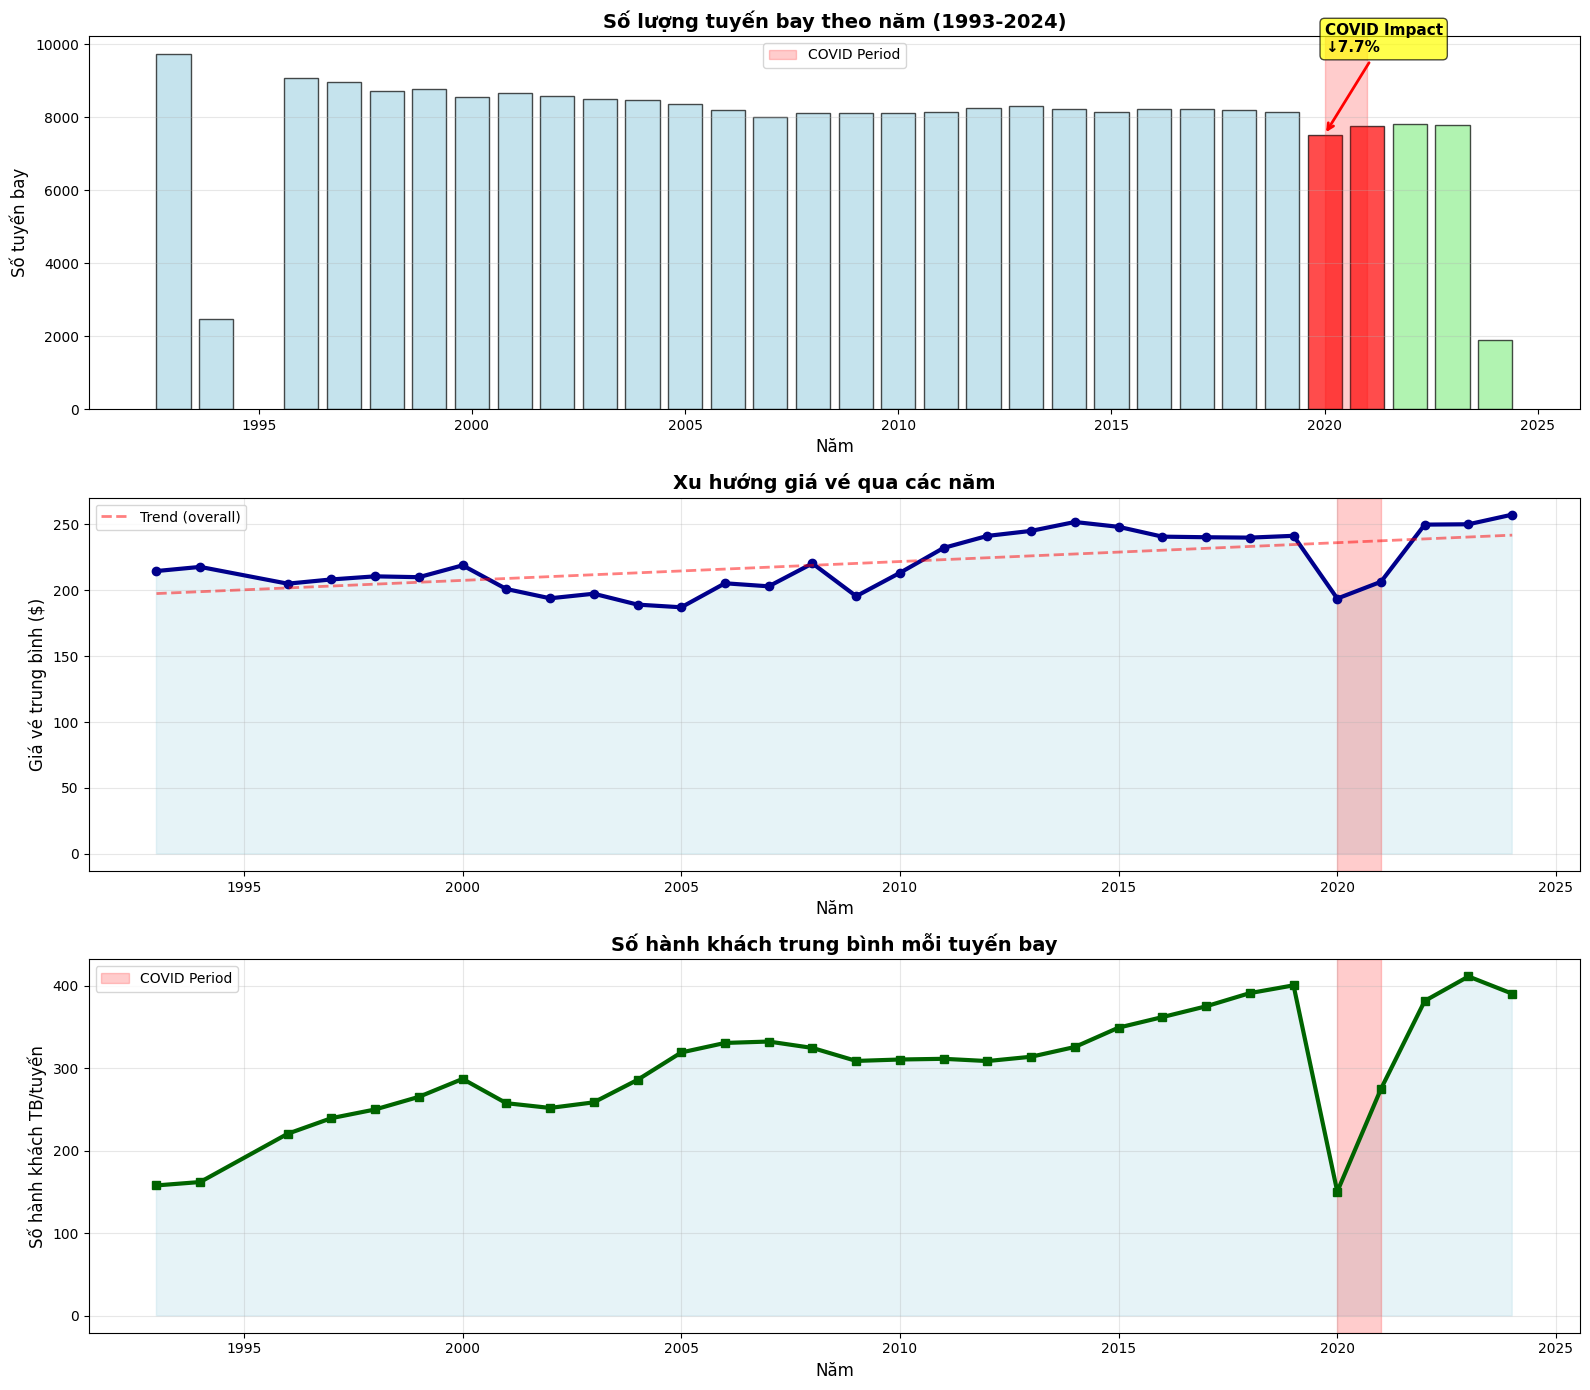

In [ ]:
# ============================================================
# CELL 9B: TRỰC QUAN HÓA TÁC ĐỘNG COVID-19
# ============================================================
# Mục đích: Vẽ timeline để thấy rõ sự thay đổi

import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import when, col, count, avg, sum # This import is likely not needed here as df_with_period is already created

fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Colors cho periods
colors = yearly_stats['period'].map({
    'Pre-COVID': 'lightblue',
    'COVID': 'red',
    'Post-COVID': 'lightgreen'
})

# 1. SỐ TUYẾN BAY THEO NĂM
axes[0].bar(yearly_stats['Year'], yearly_stats['num_routes'],
            color=colors, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Năm', fontsize=12)
axes[0].set_ylabel('Số tuyến bay', fontsize=12)
axes[0].set_title('Số lượng tuyến bay theo năm (1993-2024)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Highlight COVID period
axes[0].axvspan(2020, 2021, alpha=0.2, color='red', label='COVID Period')

# Thêm annotation
covid_routes = yearly_stats[yearly_stats['Year'] == 2020]['num_routes'].values[0]
pre_covid_avg = yearly_stats[yearly_stats['Year'] == 2019]['num_routes'].values[0]
drop_pct = ((pre_covid_avg - covid_routes) / pre_covid_avg) * 100

axes[0].annotate(f'COVID Impact\n↓{drop_pct:.1f}%',
                 xy=(2020, covid_routes),
                 xytext=(2020, covid_routes * 1.3),
                 arrowprops=dict(arrowstyle='->', color='red', lw=2),
                 fontsize=11, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
axes[0].legend()

# 2. GIÁ VÉ TRUNG BÌNH THEO NĂM
axes[1].plot(yearly_stats['Year'], yearly_stats['avg_fare'],
             linewidth=3, marker='o', markersize=6, color='darkblue')

# Fill areas
axes[1].fill_between(yearly_stats['Year'], yearly_stats['avg_fare'],
                      alpha=0.3, color=colors)
axes[1].set_xlabel('Năm', fontsize=12)
axes[1].set_ylabel('Giá vé trung bình ($)', fontsize=12)
axes[1].set_title('Xu hướng giá vé qua các năm', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axvspan(2020, 2021, alpha=0.2, color='red')

# Thêm trend line
z = np.polyfit(yearly_stats['Year'], yearly_stats['avg_fare'], 1)
p = np.poly1d(z)
axes[1].plot(yearly_stats['Year'], p(yearly_stats['Year']),
             "r--", linewidth=2, alpha=0.5, label='Trend (overall)')
axes[1].legend()

# 3. SỐ HÀNH KHÁCH TRUNG BÌNH
axes[2].plot(yearly_stats['Year'], yearly_stats['avg_passengers'],
             linewidth=3, marker='s', markersize=6, color='darkgreen')
axes[2].fill_between(yearly_stats['Year'], yearly_stats['avg_passengers'],
                      alpha=0.3, color=colors)
axes[2].set_xlabel('Năm', fontsize=12)
axes[2].set_ylabel('Số hành khách TB/tuyến', fontsize=12)
axes[2].set_title('Số hành khách trung bình mỗi tuyến bay', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].axvspan(2020, 2021, alpha=0.2, color='red', label='COVID Period')
axes[2].legend()

plt.tight_layout()
plt.savefig('../image/covid_impact_timeline.png', dpi=300, bbox_inches='tight')
plt.show()

## 2.2 Xử lý các giá trị để tạp tín hiệu bất thường

In [ ]:
# ============================================================
# CELL 11A: XỬ LÝ DỮ LIỆU ĐẦU VÀO - CRISIS DETECTION
# ============================================================
# Mục đích: Aggregate data theo quarter và tạo features

print("=" * 70)
print("XỬ LÝ DỮ LIỆU ĐẦU VÀO CHO CRISIS DETECTION")
print("=" * 70)

from pyspark.sql.functions import *
from pyspark.sql import Window

# Bước 1: Aggregate data theo Year-Quarter
print("\n1. AGGREGATE DATA THEO YEAR-QUARTER...")

df_quarterly = df.groupBy('Year', 'quarter').agg(
    # Volume metrics
    count('*').alias('num_routes'),
    sum('passengers').alias('total_passengers'),
    avg('passengers').alias('avg_passengers_per_route'),

    # Price metrics
    avg('fare').alias('avg_fare'),
    stddev('fare').alias('fare_std'),
    min('fare').alias('fare_min'),
    max('fare').alias('fare_max'),

    # Distance metrics
    avg('nsmiles').alias('avg_distance'),
    stddev('nsmiles').alias('distance_std'),

    # Competition metrics
    countDistinct('carrier_lg').alias('num_carriers'),
    avg('large_ms').alias('avg_market_share_large'),
    avg('lf_ms').alias('avg_market_share_lowcost')
).orderBy('Year', 'quarter')

# Tạo time_period identifier
df_quarterly = df_quarterly.withColumn('time_period',
    concat(col('Year').cast('string'), lit('-Q'), col('quarter').cast('string'))
)

print(f"  ✓ Aggregated to {df_quarterly.count()} quarters")

# Hiển thị sample
print("\n  Sample data:")
df_quarterly.select('time_period', 'num_routes', 'total_passengers', 'avg_fare').show(10)

# Bước 2: Tạo labels (COVID = crisis)
print("\n2. TẠO LABELS (COVID = CRISIS)...")

df_quarterly = df_quarterly.withColumn('is_crisis',
    when((col('Year') >= 2020) & (col('Year') <= 2021), 1.0)
    .otherwise(0.0)
)

# Kiểm tra phân bố labels
label_distribution = df_quarterly.groupBy('is_crisis').count()
print("\n  Phân bố labels:")
label_distribution.show()

# Bước 3: Feature Engineering - Rate of Change
print("\n3. FEATURE ENGINEERING - RATE OF CHANGE...")

# Window specs
window_qoq = Window.orderBy('Year', 'quarter')
window_yoy = Window.orderBy('Year', 'quarter').rowsBetween(-4, -4)

# QoQ (Quarter-over-Quarter) changes
change_cols = ['num_routes', 'total_passengers', 'avg_fare', 'avg_distance']

for col_name in change_cols:
    # Lấy giá trị quarter trước
    df_quarterly = df_quarterly.withColumn(
        f'{col_name}_prev_q',
        lag(col(col_name), 1).over(window_qoq)
    )

    # Tính % change
    df_quarterly = df_quarterly.withColumn(
        f'{col_name}_change_qoq',
        when(col(f'{col_name}_prev_q').isNotNull() & (col(f'{col_name}_prev_q') != 0),
             (col(col_name) - col(f'{col_name}_prev_q')) / col(f'{col_name}_prev_q'))
        .otherwise(0.0)
    )

    # Drop temp column
    df_quarterly = df_quarterly.drop(f'{col_name}_prev_q')

print("  ✓ QoQ changes calculated")

# YoY (Year-over-Year) changes
yoy_cols = ['num_routes', 'total_passengers', 'avg_fare']

for col_name in yoy_cols:
    df_quarterly = df_quarterly.withColumn(
        f'{col_name}_prev_year',
        lag(col(col_name), 4).over(window_qoq)
    )

    df_quarterly = df_quarterly.withColumn(
        f'{col_name}_change_yoy',
        when(col(f'{col_name}_prev_year').isNotNull() & (col(f'{col_name}_prev_year') != 0),
             (col(col_name) - col(f'{col_name}_prev_year')) / col(f'{col_name}_prev_year'))
        .otherwise(0.0)
    )

    df_quarterly = df_quarterly.drop(f'{col_name}_prev_year')

print("  ✓ YoY changes calculated")

# Bước 4: Derived features
print("\n4. CREATING DERIVED FEATURES...")

# Volatility metrics
df_quarterly = df_quarterly.withColumn('fare_volatility',
    when(col('avg_fare') != 0, col('fare_std') / col('avg_fare')).otherwise(0.0)
)

df_quarterly = df_quarterly.withColumn('distance_volatility',
    when(col('avg_distance') != 0, col('distance_std') / col('avg_distance')).otherwise(0.0)
)

# Range metrics
df_quarterly = df_quarterly.withColumn('fare_range',
    col('fare_max') - col('fare_min')
)

# Passenger efficiency
df_quarterly = df_quarterly.withColumn('passenger_efficiency',
    when(col('num_routes') != 0, col('total_passengers') / col('num_routes')).otherwise(0.0)
)

print("  ✓ Derived features created")

# Bước 5: Handle missing values
print("\n5. HANDLING MISSING VALUES...")

# Fill NaN với 0 (từ lag functions cho first rows)
df_quarterly = df_quarterly.fillna(0.0)

missing_check = df_quarterly.select([count(when(col(c).isNull(), c)).alias(c)
                                      for c in df_quarterly.columns])
print("\n  Missing values check:")
missing_check.show()

# Bước 6: Select final features
print("\n6. SELECTING FEATURES FOR MODEL...")

feature_cols_final = [
    # Core volume metrics (3)
    'num_routes',
    'total_passengers',
    'avg_passengers_per_route',

    # Core price metrics (2)
    'avg_fare',
    'avg_distance',

    # Volatility metrics (2)
    'fare_volatility',
    'fare_range',

    # QoQ changes - IMPORTANT! (4)
    'num_routes_change_qoq',
    'total_passengers_change_qoq',
    'avg_fare_change_qoq',
    'avg_distance_change_qoq',

    # YoY changes (3)
    'num_routes_change_yoy',
    'total_passengers_change_yoy',
    'avg_fare_change_yoy',

    # Competition (2)
    'num_carriers',
    'avg_market_share_large',

    # Seasonal (1)
    'quarter',
]

print(f"\n  Tổng số features: {len(feature_cols_final)}")
print(f"\n  Danh sách features:")
for i, feat in enumerate(feature_cols_final, 1):
    print(f"    {i:2}. {feat}")

# Hiển thị final dataset
print("\n7. FINAL DATASET:")
df_quarterly.select(['time_period', 'Year', 'quarter', 'is_crisis'] +
                    feature_cols_final[:5]).show(15)

print(f"\n✓ Data preparation completed!")
print(f"  Total quarters: {df_quarterly.count()}")
print(f"  Total features: {len(feature_cols_final)}")
print(f"  Target: is_crisis (0 = Normal, 1 = COVID)")

XỬ LÝ DỮ LIỆU ĐẦU VÀO CHO CRISIS DETECTION

1. AGGREGATE DATA THEO YEAR-QUARTER...
  ✓ Aggregated to 118 quarters

  Sample data:
+-----------+----------+----------------+------------------+
|time_period|num_routes|total_passengers|          avg_fare|
+-----------+----------+----------------+------------------+
|    1993-Q1|      2395|          345741|236.60088935281794|
|    1993-Q2|      2459|          403857|209.41590483936557|
|    1993-Q3|      2448|          393045| 198.8709232026143|
|    1993-Q4|      2437|          395495|213.50024620434954|
|    1994-Q1|      2454|          397667| 217.6119437652813|
|    1996-Q1|      2270|          455842|210.39099118942724|
|    1996-Q2|      2317|          528950| 202.4628614587828|
|    1996-Q3|      2266|          513137|201.06954545454542|
|    1996-Q4|      2228|          504663|205.73692998204706|
|    1997-Q1|      2243|          498839|211.33452073116342|
+-----------+----------+----------------+------------------+
only showing top

## 2.3 Công việc tiếp theo

Huấn luyện mô hình để dự đoán bất thường, cảnh báo thảm họa hàng không

# 3 Airline market share prediction model

In [ ]:
feature_cols = numeric_features + [col+"_indexed" for col in categorical_features]
feature_cols.append('is_largest_cheapest')

In [ ]:
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features_raw"
)

In [ ]:
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withStd=True,
    withMean=True
)

In [ ]:
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

print(f"\n=== CHIA DỮ LIỆU ===")
print(f"Số dòng train: {train_data.count()}")
print(f"Số dòng test: {test_data.count()}")


=== CHIA DỮ LIỆU ===
Số dòng train: 190123
Số dòng test: 47862


In [ ]:
lr = LinearRegression(
    featuresCol="features",
    labelCol="large_ms",
    maxIter=100,
    regParam=0.1,
    elasticNetParam=0.5
)

In [ ]:
pipeline_lr = Pipeline(stages=indexers + [assembler, scaler, lr])
model_lr = pipeline_lr.fit(train_data)
predictions_lr = model_lr.transform(test_data)

In [ ]:
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="large_ms",
    numTrees=100,
    maxDepth=10,
    seed=42
)

In [ ]:
pipeline_rf = Pipeline(stages=indexers + [assembler, scaler, rf])
model_rf = pipeline_rf.fit(train_data)
predictions_rf = model_rf.transform(test_data)

In [ ]:
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="large_ms",
    maxIter=100,
    maxDepth=5,
    seed=42
)

In [ ]:

pipeline_gbt = Pipeline(stages=indexers + [assembler, scaler, gbt])
model_gbt = pipeline_gbt.fit(train_data)
predictions_gbt = model_gbt.transform(test_data)

In [ ]:
evaluator_rmse = RegressionEvaluator(
    labelCol="large_ms",
    predictionCol="prediction",
    metricName="rmse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="large_ms",
    predictionCol="prediction",
    metricName="r2"
)

evaluator_mae = RegressionEvaluator(
    labelCol="large_ms",
    predictionCol="prediction",
    metricName="mae"
)

In [ ]:
print("\nLinear Regression:")
print(f"  RMSE: {evaluator_rmse.evaluate(predictions_lr):.4f}")
print(f"  R2: {evaluator_r2.evaluate(predictions_lr):.4f}")
print(f"  MAE: {evaluator_mae.evaluate(predictions_lr):.4f}")

print("\nRandom Forest:")
print(f"  RMSE: {evaluator_rmse.evaluate(predictions_rf):.4f}")
print(f"  R2: {evaluator_r2.evaluate(predictions_rf):.4f}")
print(f"  MAE: {evaluator_mae.evaluate(predictions_rf):.4f}")

print("\nGradient Boosted Trees:")
print(f"  RMSE: {evaluator_rmse.evaluate(predictions_gbt):.4f}")
print(f"  R2: {evaluator_r2.evaluate(predictions_gbt):.4f}")
print(f"  MAE: {evaluator_mae.evaluate(predictions_gbt):.4f}")


Linear Regression:
  RMSE: 0.1943
  R2: 0.2376
  MAE: 0.1699

Random Forest:
  RMSE: 0.0840
  R2: 0.8573
  MAE: 0.0554

Gradient Boosted Trees:
  RMSE: 0.0765
  R2: 0.8818
  MAE: 0.0481


In [ ]:
rf_model = model_rf.stages[-1]
feature_importance = rf_model.featureImportances.toArray()

feature_names = feature_cols
importance_df = spark.createDataFrame(
    [(name, float(imp)) for name, imp in zip(feature_names, feature_importance)],
    ['feature', 'importance']
).orderBy(col('importance').desc())

importance_df.show(20)

+-------------------+--------------------+
|            feature|          importance|
+-------------------+--------------------+
|              lf_ms|  0.6691844630064311|
|    fare_difference| 0.13569947965126553|
|            nsmiles| 0.06421050930453445|
|      fare_per_mile| 0.03515753599119153|
|is_largest_cheapest|0.034181782479342816|
|            revenue| 0.01794006182416434|
|         passengers|0.016684549979397834|
| carrier_lg_indexed|0.010819914920363834|
|               Year|0.006604698071603944|
|carrier_low_indexed|0.004857337121019847|
|               fare|0.002854490995978...|
|           fare_low|0.001720933992446...|
|            quarter|8.424266225933034E-5|
+-------------------+--------------------+



In [ ]:
predictions_rf.select(
    'large_ms', 'prediction',
    'passengers', 'fare', 'nsmiles', 'carrier_lg'
).show(10)

+--------+------------------+----------+------+-------+----------+
|large_ms|        prediction|passengers|  fare|nsmiles|carrier_lg|
+--------+------------------+----------+------+-------+----------+
|    0.85|0.8534900135796164|       133|275.63|    654|        UA|
|    0.37|0.5309484391287608|         4|267.08|   1974|        US|
|    0.26|0.4312600977159158|        68|258.75|   1670|        DL|
|    0.83|0.8495292097959413|        57|139.36|   1123|        WN|
|    0.66| 0.646960262991727|         4|223.75|   1861|        NW|
|     0.8|0.7667079022924445|         7| 326.4|   1861|        DL|
|    0.94|0.9354262355257376|       888| 86.67|    677|        WN|
|    0.53|0.4827445549495522|        23|289.51|   1504|        UA|
|     0.5|0.4973493884381909|        26|222.54|    963|        UA|
|    0.44|0.5055744906018458|        71|204.62|    963|        UA|
+--------+------------------+----------+------+-------+----------+
only showing top 10 rows



In [ ]:
lr = LinearRegression(featuresCol="features", labelCol="large_ms", maxIter=100)

In [ ]:
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.01, 0.1, 0.5, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0]) \
    .addGrid(lr.maxIter, [50, 100, 200]) \
    .build()

In [ ]:
# Cross-validator
cv_lr = CrossValidator(
    estimator=Pipeline(stages=indexers + [assembler, scaler, lr]),
    estimatorParamMaps=paramGrid_lr,
    evaluator=evaluator_rmse,
    numFolds=3,  # 3-fold cross-validation
    parallelism=2,
    seed=42
)

In [ ]:
cv_model_lr = cv_lr.fit(train_data)

In [ ]:
best_lr_model = cv_model_lr.bestModel.stages[-1]
print("Best parameters cho Linear Regression:")
print(f"  regParam: {best_lr_model.getRegParam()}")
print(f"  elasticNetParam: {best_lr_model.getElasticNetParam()}")
print(f"  maxIter: {best_lr_model.getMaxIter()}\n")

Best parameters cho Linear Regression:
  regParam: 0.0
  elasticNetParam: 0.0
  maxIter: 50



In [ ]:
predictions_lr = cv_model_lr.transform(test_data)
print("Kết quả trên Test Set:")
print(f"  RMSE: {evaluator_rmse.evaluate(predictions_lr):.4f}")
print(f"  R²: {evaluator_r2.evaluate(predictions_lr):.4f}")
print(f"  MAE: {evaluator_mae.evaluate(predictions_lr):.4f}\n")

Kết quả trên Test Set:
  RMSE: 0.1721
  R²: 0.4013
  MAE: 0.1381



In [ ]:
# Cross-validation scores
cv_scores_lr = cv_model_lr.avgMetrics
print("Cross-Validation Scores (RMSE):")
for idx, score in enumerate(cv_scores_lr[:5]):  # Top 5
    print(f"  Config {idx+1}: {score:.4f}")


Cross-Validation Scores (RMSE):
  Config 1: 0.1725
  Config 2: 0.1725
  Config 3: 0.1725
  Config 4: 0.1725
  Config 5: 0.1725


In [ ]:
rf = RandomForestRegressor(featuresCol="features", labelCol="large_ms", seed=42)
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 150]) \
    .addGrid(rf.maxDepth, [5, 10, 15, 20]) \
    .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .build()

In [ ]:
# TrainValidationSplit (nhanh hơn CrossValidator cho RF)
tvs_rf = TrainValidationSplit(
    estimator=Pipeline(stages=indexers + [assembler, scaler, rf]),
    estimatorParamMaps=paramGrid_rf,
    evaluator=evaluator_rmse,
    trainRatio=0.8,  # 80% train, 20% validation
    parallelism=2,
    seed=42
)

In [ ]:
tvs_model_rf = tvs_rf.fit(train_data)

In [ ]:
# Best parameters
best_rf_model = tvs_model_rf.bestModel.stages[-1]
print("Best parameters cho Random Forest:")
print(f"  numTrees: {best_rf_model.getNumTrees}")
print(f"  maxDepth: {best_rf_model.getMaxDepth()}")
print(f"  minInstancesPerNode: {best_rf_model.getMinInstancesPerNode()}")
print(f"  maxBins: {best_rf_model.getMaxBins()}\n")

Best parameters cho Random Forest:
  numTrees: 150
  maxDepth: 20
  minInstancesPerNode: 1
  maxBins: 64



In [ ]:
# Đánh giá trên test set
predictions_rf = tvs_model_rf.transform(test_data)
print("Kết quả trên Test Set:")
print(f"  RMSE: {evaluator_rmse.evaluate(predictions_rf):.4f}")
print(f"  R²: {evaluator_r2.evaluate(predictions_rf):.4f}")
print(f"  MAE: {evaluator_mae.evaluate(predictions_rf):.4f}\n")

Kết quả trên Test Set:
  RMSE: 0.0670
  R²: 0.9092
  MAE: 0.0394



In [ ]:
# GBT với hyperparameter tuning
gbt = GBTRegressor(featuresCol="features", labelCol="large_ms", seed=42)

# Param grid cho GBT
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [50, 100, 150]) \
    .addGrid(gbt.maxDepth, [3, 5, 7]) \
    .addGrid(gbt.stepSize, [0.01, 0.1, 0.2]) \
    .addGrid(gbt.subsamplingRate, [0.8, 1.0]) \
    .build()

In [ ]:
# TrainValidationSplit cho GBT
tvs_gbt = TrainValidationSplit(
    estimator=Pipeline(stages=indexers + [assembler, scaler, gbt]),
    estimatorParamMaps=paramGrid_gbt,
    evaluator=evaluator_rmse,
    trainRatio=0.8,
    parallelism=2,
    seed=42
)

In [ ]:
tvs_model_gbt = tvs_gbt.fit(train_data)

In [ ]:
# Best parameters
best_gbt_model = tvs_model_gbt.bestModel.stages[-1]
print("Best parameters cho GBT:")
print(f"  maxIter: {best_gbt_model.getMaxIter()}")
print(f"  maxDepth: {best_gbt_model.getMaxDepth()}")
print(f"  stepSize: {best_gbt_model.getStepSize()}")
print(f"  subsamplingRate: {best_gbt_model.getSubsamplingRate()}\n")

Best parameters cho GBT:
  maxIter: 150
  maxDepth: 7
  stepSize: 0.1
  subsamplingRate: 1.0



In [ ]:
# Đánh giá trên test set
predictions_gbt = tvs_model_gbt.transform(test_data)
print("Kết quả trên Test Set:")
print(f"  RMSE: {evaluator_rmse.evaluate(predictions_gbt):.4f}")
print(f"  R²: {evaluator_r2.evaluate(predictions_gbt):.4f}")
print(f"  MAE: {evaluator_mae.evaluate(predictions_gbt):.4f}\n")

Kết quả trên Test Set:
  RMSE: 0.0695
  R²: 0.9024
  MAE: 0.0429



# 4 Building a potential classification model

## Prepare for model training

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, lit, when, round

# STEP 1: CALCULATE POTENTIAL SCORE (POTENTIAL SCORE)
print("BƯỚC 1: TÍNH TOÁN ĐIỂM SỐ TIỀM NĂNG")
print("="*50)

# Make a copy of the data for processing
df_potential = df_clean

# Normalize metrics to [0,1] scale
metrics = ['passengers', 'fare', 'nsmiles', 'large_ms', 'lf_ms']

# Calculate min and max for normalization
min_max_stats = {}
for metric in metrics:
    if metric in df_potential.columns:
        stats = df_potential.select(
            F.min(col(metric)).alias("min_val"),
            F.max(col(metric)).alias("max_val")
        ).collect()[0]
        min_max_stats[metric] = {
            'min': stats['min_val'],
            'max': stats['max_val']
        }

# Normalization each metrics
for metric in metrics:
    if metric in df_potential.columns and metric in min_max_stats:
        min_val = min_max_stats[metric]['min']
        max_val = min_max_stats[metric]['max']
        if max_val != min_val:
            df_potential = df_potential.withColumn(
                f'{metric}_normalized',
                (col(metric) - lit(min_val)) / (lit(max_val) - lit(min_val))
            )
        else:
            df_potential = df_potential.withColumn(f'{metric}_normalized', lit(0.0))

# Calculate potential score based on weight
weights = {
    'passengers_normalized': 0.25,
    'fare_normalized': 0.2,
    'nsmiles_normalized': 0.25,
    'large_ms_normalized': 0.15,
    'lf_ms_normalized': 0.15
}

potential_score_expr = lit(0.0)
for metric, weight in weights.items():
    if metric in df_potential.columns:
        potential_score_expr = potential_score_expr + (col(metric) * weight)

df_potential = df_potential.withColumn('potential_score', potential_score_expr)

# Classify based on potential score
df_potential = df_potential.withColumn(
    'potential_level',
    when(col('potential_score') > 0.4, 'Cao')
    .when(col('potential_score') >= 0.3, 'Trung bình')
    .otherwise('Thấp')
)

# Distribution statistics
print("\nPhân bố tiềm năng tuyến bay:")
potential_dist = df_potential.groupBy('potential_level').count().orderBy('potential_level')
potential_dist.show()

# Calculate percentage
total_count = df_potential.count()
potential_percentages = df_potential.groupBy('potential_level').count() \
    .withColumn('percentage', round(col('count') / lit(total_count) * 100, 3)) \
    .orderBy('potential_level')

print("\nTỷ lệ phần trăm:")
potential_percentages.show()


BƯỚC 1: TÍNH TOÁN ĐIỂM SỐ TIỀM NĂNG

Phân bố tiềm năng tuyến bay:
+---------------+------+
|potential_level| count|
+---------------+------+
|            Cao| 27047|
|           Thấp|120694|
|     Trung bình| 90244|
+---------------+------+


Tỷ lệ phần trăm:
+---------------+------+----------+
|potential_level| count|percentage|
+---------------+------+----------+
|            Cao| 27047|    11.365|
|           Thấp|120694|    50.715|
|     Trung bình| 90244|     37.92|
+---------------+------+----------+



In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import first, last, col, lit, when

# STEP 2: ADDITIONAL GROWTH TREND ANALYSISA
print("\nBƯỚC 2: PHÂN TÍCH XU HƯỚNG TĂNG TRƯỞNG")
print("=" * 50)

# Create window partitioned by route (city1, city2) ordered by Year
window_spec = Window.partitionBy('city1', 'city2').orderBy('Year') \
                   .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# Calculate first and last values for each route
df_with_growth = df_potential.withColumn(
    'first_passengers', first('passengers').over(window_spec)
).withColumn(
    'last_passengers', last('passengers').over(window_spec)
).withColumn(
    'first_fare', first('fare').over(window_spec)
).withColumn(
    'last_fare', last('fare').over(window_spec)
)

# Calculate growth rates
df_with_growth = df_with_growth.withColumn(
    'passenger_growth',
    when(col('first_passengers') > 0,
         (col('last_passengers') - col('first_passengers')) / col('first_passengers'))
    .otherwise(0)
).withColumn(
    'fare_growth',
    when(col('first_fare') > 0,
         (col('last_fare') - col('first_fare')) / col('first_fare'))
    .otherwise(0)
)

# Calculate growth trends score (70% passengers, 30% fare)
df_with_growth = df_with_growth.withColumn(
    'growth_trend',
    0.7 * col('passenger_growth') + 0.3 * col('fare_growth')
)

# Normalize growth trends to [0,1]
growth_stats = df_with_growth.select(
    F.min('growth_trend').alias('min_growth'),
    F.max('growth_trend').alias('max_growth')
).collect()[0]

min_growth = growth_stats['min_growth']
max_growth = growth_stats['max_growth']

if max_growth != min_growth:
    df_with_growth = df_with_growth.withColumn(
        'growth_trend_normalized',
        (col('growth_trend') - lit(min_growth)) / (lit(max_growth) - lit(min_growth))
    )
else:
    df_with_growth = df_with_growth.withColumn('growth_trend_normalized', lit(0.0))

# Update potential score with growth trend (10% weight)
df_potential = df_with_growth.withColumn(
    'potential_score_enhanced',
    col('potential_score') * 0.9 + col('growth_trend_normalized') * 0.1
)

# Reclassify based on enhanced potential score
df_potential = df_potential.withColumn(
    'potential_level_enhanced',
    when(col('potential_score_enhanced') > 0.4, 'Cao')
    .when(col('potential_score_enhanced') >= 0.3, 'Trung bình')
    .otherwise('Thấp')
)

# Display distribution results
print("\nPhân bố tiềm năng sau khi cải tiến:")
enhanced_dist = df_potential.groupBy('potential_level_enhanced').count().orderBy('potential_level_enhanced')
enhanced_dist.show()



BƯỚC 2: PHÂN TÍCH XU HƯỚNG TĂNG TRƯỞNG

Phân bố tiềm năng sau khi cải tiến:
+------------------------+------+
|potential_level_enhanced| count|
+------------------------+------+
|                     Cao| 12437|
|                    Thấp|151411|
|              Trung bình| 74137|
+------------------------+------+



In [ ]:
# STEP 3: TRAIN MACHINE LEARNING MODEL

print("\nBƯỚC 3: HUẤN LUYỆN MÔ HÌNH MACHINE LEARNING")
print("="*50)

# # Prepare features
features_ml = ['passengers', 'fare', 'nsmiles', 'large_ms', 'lf_ms', 'fare_lg', 'fare_low', 'growth_trend']

# Create feature vector
assembler = VectorAssembler(
    inputCols=features_ml,
    outputCol="features"
)

# String indexer for target variable
label_indexer = StringIndexer(
    inputCol="potential_level_enhanced",
    outputCol="label"
)
# Create pipeline for feature preparation
feature_pipeline = Pipeline(stages=[assembler, label_indexer])
df_ml = feature_pipeline.fit(df_potential).transform(df_potential)

# Split data (80% train , 20% test)
train_data, test_data = df_ml.randomSplit([0.8, 0.2], seed=42)

print(f"Kích thước dữ liệu:")
print(f"  - Train: {train_data.count()} mẫu")
print(f"  - Test: {test_data.count()} mẫu")
print(f"  - Số đặc trưng: {len(features_ml)}")


BƯỚC 3: HUẤN LUYỆN MÔ HÌNH MACHINE LEARNING
Kích thước dữ liệu:
  - Train: 190573 mẫu
  - Test: 47412 mẫu
  - Số đặc trưng: 8


In [ ]:
# Function to evaluate model
def evaluate_model(predictions):
    evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    evaluator_pre = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
    evaluator_rec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

    accuracy = evaluator_acc.evaluate(predictions)
    precision = evaluator_pre.evaluate(predictions)
    recall = evaluator_rec.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)

    print(f"  - Accuracy : {accuracy:.4f}")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall   : {recall:.4f}")
    print(f"  - F1-Score : {f1:.4f}")

    return accuracy

## `Random Forest`

###  `Random Forest` Training

In [ ]:
# RANDOM FOREST
from pyspark.ml.classification import RandomForestClassifier

print("\n HUẤN LUYỆN MÔ HÌNH: Random Forest")
print("-" * 60)

rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=20,
    maxDepth=5,
    seed=42)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

print("Kết quả đánh giá Random Forest:")
rf_accuracy = evaluate_model(rf_predictions)


 HUẤN LUYỆN MÔ HÌNH: Random Forest
------------------------------------------------------------
Kết quả đánh giá Random Forest:
  - Accuracy : 0.8924
  - Precision: 0.8946
  - Recall   : 0.8924
  - F1-Score : 0.8925


###  `Random Forest` – Find optimal hyperparameters - numTrees, maxDepth, maxBins

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)

paramGrid_rf = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [35, 50, 75, 100])
    .addGrid(rf.maxDepth, [5, 10, 15])
    .addGrid(rf.maxBins, [32, 64])
    .build()
)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

cv_rf = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid_rf,
    evaluator=evaluator,
    numFolds=3,
    parallelism=1,
    seed=42
)

cvModel_rf = cv_rf.fit(train_data)
best_rf_model = cvModel_rf.bestModel
rf_predictions = best_rf_model.transform(test_data)

print(" Best Random Forest parameters:")
print(f"  numTrees = {best_rf_model.getNumTrees}")
print(f"  maxDepth = {best_rf_model.getOrDefault('maxDepth')}")
print(f"  maxBins  = {best_rf_model.getOrDefault('maxBins')}")

rf_accuracy = evaluator.evaluate(rf_predictions)
print(f" Accuracy (Random Forest): {rf_accuracy:.4f}")


 Best Random Forest parameters:
  numTrees = 100
  maxDepth = 15
  maxBins  = 64
 Accuracy (Random Forest): 0.9794


## `Logistic Regression`

### `Logistic Regression` Training



In [ ]:
# LOGISTIC REGRESSION
from pyspark.ml.classification import LogisticRegression

print("\n HUẤN LUYỆN MÔ HÌNH: Logistic Regression")
print("-" * 60)

# Chỉ có L2 regularization
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=100,
    regParam=0.01)
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

print("Kết quả đánh giá Logistic Regression:")
lr_accuracy = evaluate_model(lr_predictions)



 HUẤN LUYỆN MÔ HÌNH: Logistic Regression
------------------------------------------------------------
Kết quả đánh giá Logistic Regression:
  - Accuracy : 0.9421
  - Precision: 0.9451
  - Recall   : 0.9421
  - F1-Score : 0.9365


### `Logistic Regression` – Find optimal hyperparameters - regParam, elasticNetParam

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=1000)

paramGrid_lr = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.001, 0.1, 0.3, 0.5, 1.0])
    .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])  # 0=L2, 1=L1
    .build()
)

cv_lr = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid_lr,
    evaluator=evaluator,
    numFolds=3,
    parallelism=1,
    seed=42
)

cvModel_lr = cv_lr.fit(train_data)
best_lr_model = cvModel_lr.bestModel
lr_predictions = best_lr_model.transform(test_data)

print(" Best Logistic Regression parameters:")
print(f"  regParam = {best_lr_model.getRegParam()}")
print(f"  elasticNetParam = {best_lr_model.getElasticNetParam()}")

lr_accuracy = evaluator.evaluate(lr_predictions)
print(f" Accuracy (Logistic Regression): {lr_accuracy:.4f}")


 Best Logistic Regression parameters:
  regParam = 0.001
  elasticNetParam = 1.0
 Accuracy (Logistic Regression): 0.9950


## Find the best model

In [ ]:
import builtins  # dùng max gốc của Python

models_info = [
    {
        "name": "Random Forest",
        "accuracy": rf_accuracy,
        "params": {
            "numTrees": best_rf_model.getNumTrees,
            "maxDepth": best_rf_model.getOrDefault("maxDepth"),
            "maxBins": best_rf_model.getOrDefault("maxBins")
        }
    },
    {
        "name": "Logistic Regression",
        "accuracy": lr_accuracy,
        "params": {
            "regParam": best_lr_model.getRegParam(),
            "elasticNetParam": best_lr_model.getElasticNetParam()
        }
    }
]

# Dùng builtins.max
best_model = builtins.max(models_info, key=lambda m: m["accuracy"])

print("\n So sánh mô hình:")
for m in models_info:
    marker = "" if m["name"] == best_model["name"] else "  "
    print(f"{marker} {m['name']}: Accuracy = {m['accuracy']:.4f}")
    for k, v in m["params"].items():
        print(f"     {k}: {v}")
    print("-" * 50)

print(f"\n Mô hình tốt nhất: {best_model['name']} (Độ chính xác = {best_model['accuracy']:.4f})")
print("  Siêu tham số tối ưu:")
for k, v in best_model["params"].items():
    print(f"   {k}: {v}")



 So sánh mô hình:
   Random Forest: Accuracy = 0.9794
     numTrees: 100
     maxDepth: 15
     maxBins: 64
--------------------------------------------------
 Logistic Regression: Accuracy = 0.9950
     regParam: 0.001
     elasticNetParam: 1.0
--------------------------------------------------

 Mô hình tốt nhất: Logistic Regression (Độ chính xác = 0.9950)
  Siêu tham số tối ưu:
   regParam: 0.001
   elasticNetParam: 1.0


## Test

In [ ]:
from pyspark.sql.functions import udf, col, rand
from pyspark.sql.types import StringType

# Map numeric labels to string labels (based on trained StringIndexer order)
label_mapping = {0.0: "Cao", 1.0: "Trung bình", 2.0: "Thấp"}
map_label_udf = udf(lambda x: label_mapping.get(x, "Không rõ"), StringType())

# Get 10 random samples from test set
sample_test = test_data.orderBy(rand()).limit(10)

# Determine the best model
if best_model["name"] == "Random Forest":
    best_model_object = best_rf_model
elif best_model["name"] == "Logistic Regression":
    best_model_object = best_lr_model
else:
    raise ValueError("Không xác định được mô hình tốt nhất!")

# Make predictions
sample_predictions = best_model_object.transform(sample_test)

# Add true and predicted labels in string format
sample_with_labels = (
    sample_predictions
    .withColumn("Label_thật", map_label_udf(col("label")))
    .withColumn("Dự_đoán", map_label_udf(col("prediction")))
)

# Display key columns
columns_to_show = [
    "city1", "city2", "passengers", "fare", "nsmiles",
    "large_ms", "lf_ms", "fare_lg", "fare_low",
    "Label_thật", "Dự_đoán"
]

print(f"\n Dự đoán 10 mẫu ngẫu nhiên bằng mô hình tốt nhất: {best_model['name']}")
sample_with_labels.select(columns_to_show).show(truncate=False)



 Dự đoán 10 mẫu ngẫu nhiên bằng mô hình tốt nhất: Logistic Regression
+-------------------------------------+-------------------------------------+----------+------+-------+--------+------+-------+--------+----------+----------+
|city1                                |city2                                |passengers|fare  |nsmiles|large_ms|lf_ms |fare_lg|fare_low|Label_thật|Dự_đoán   |
+-------------------------------------+-------------------------------------+----------+------+-------+--------+------+-------+--------+----------+----------+
|Chicago, IL                          |Tulsa, OK                            |219       |159.12|585    |0.68    |0.28  |158.78 |157.54  |Cao       |Cao       |
|Miami, FL (Metropolitan Area)        |Pittsburgh, PA                       |218       |168.14|1013   |0.77    |0.04  |171.81 |109.38  |Cao       |Cao       |
|Indianapolis, IN                     |New York City, NY (Metropolitan Area)|447       |240.15|700    |0.77    |0.11  |250.35 |200.6  